# Investigating the range of values of interpolated data

The data analysed here was generated with `scipy.interpolate.RBFInterpolator` using `kernel="linear`.

In [38]:
%load_ext autoreload
%autoreload 2 --print
from notebook_helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
interpolated_data_path = Path(
    "/home/ediun/git/histalign/notebooks/resources/d2783eb27223868f57e159f01ce7a1b2.27.interp.npz"
)

In [4]:
interpolated_data = np.load(interpolated_data_path)["array"]

In [5]:
print(f"Data min: {interpolated_data.min()}")
print(f"Data max: {interpolated_data.max()}")

Data min: -12461.77739641114
Data max: 65535.00000000003


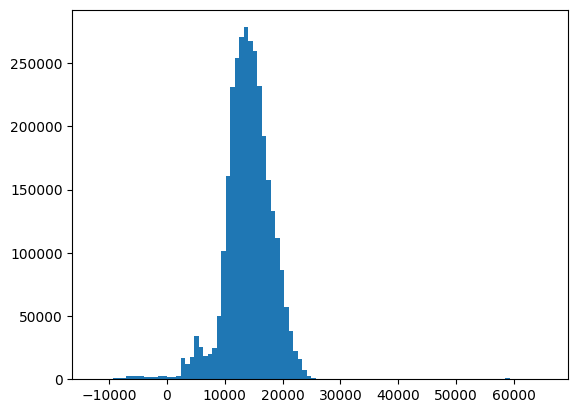

In [6]:
plt.hist(interpolated_data, bins=100)
plt.show()

There are some negative values. When inserting the values into the interpolated array, I'm wondering if the negative values might get truncated in a way to makes them bright spots.  
Let's see how numpy deals with inserting a larger datatype (i.e., float64) into an array with a smaller one (i.e., uint16).

## Checking casting/truncating rules

In [7]:
minimum_value = interpolated_data.min()
minimum_value

-12461.77739641114

In [8]:
array = np.array([0], dtype=np.uint16)
array

array([0], dtype=uint16)

In [9]:
array[0] = minimum_value
array

array([53075], dtype=uint16)

In [10]:
other_array = np.array([minimum_value]).astype(np.uint16)
other_array

array([53075], dtype=uint16)

Right, I might be correct then.

In [11]:
array = np.array([-1]).astype(np.uint16)
array

array([65535], dtype=uint16)

Right, that's probably it then. The values that are interolated are in the range -2**8 to 2**8 - 1, and converting any of the negative values to uint16 causes them to be very high.

## Investigating interpolation to understand negative values

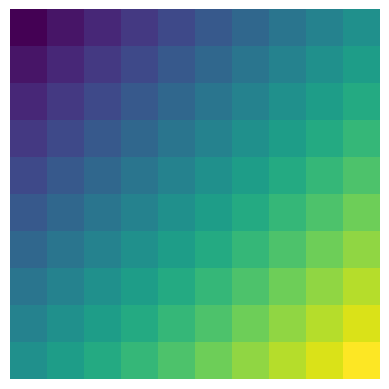

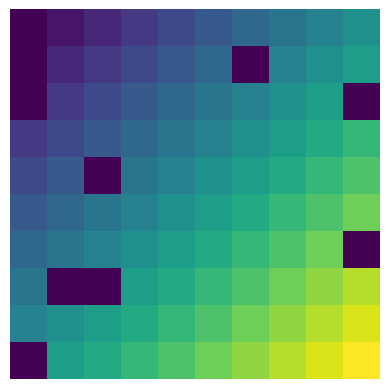

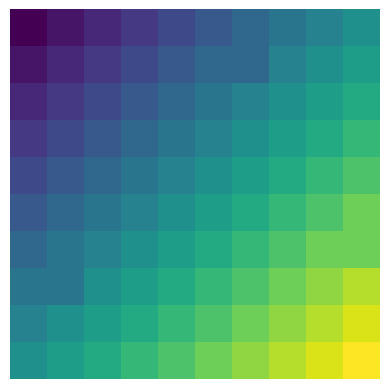

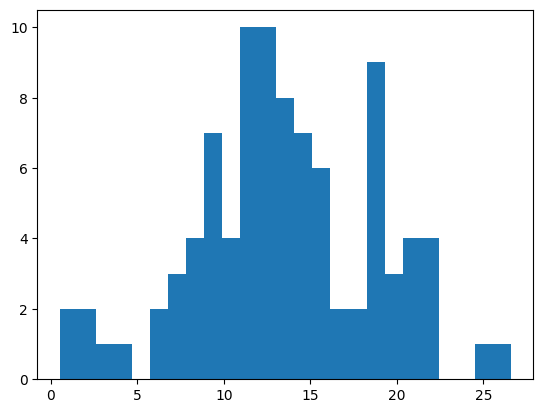

In [48]:
shape = (10, 10, 10)

data = np.array(
    [
        i + j + k
        for i in range(shape[0])
        for j in range(shape[1])
        for k in range(shape[2])
    ],
    dtype=np.uint16,
).reshape(shape)

corruption_rate = 0.1
corrupted = np.where(
    np.random.choice(
        [0, 1], p=[corruption_rate, 1 - corruption_rate], size=np.prod(shape)
    ).reshape(shape),
    data,
    0,
)

known_coordinates = np.nonzero(corrupted)
known_points = np.array(known_coordinates).T

known_values = corrupted[known_coordinates]

target_coordinates = np.nonzero(corrupted == 0)
target_points = np.array(target_coordinates).T

interpolator = RBFInterpolator(known_points, known_values, kernel="linear")

recovered_values = interpolator(target_points)
recovered = corrupted.copy()
recovered[target_coordinates] = recovered_values

imshow(data[0])
imshow(corrupted[0])
imshow(recovered[0])

plt.hist(recovered_values, bins=25)
plt.show()